In [1]:
import sys
sys.path.append('../')
from localconfig import BASE_PATH,EXPS

import pathlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
np.set_printoptions(threshold=1050)
from pprint import pprint

import maxone_code.data
import maxone_code.fig
from maxone_code.data import Experiment
from maxone_code.artifact.remover import ArtifactAssay

## 計測データの確認
- 計測データ、計測電極、刺激電極を読み込む
- 指定した刺激インターバルから刺激開始フレームを推定。

In [2]:
EXP,FILE=(EXPS[0],'searching-5764-5764.raw.h5')
# EXP,FILE=(EXPS[2],'searching-984-983.raw.h5')
# EXP,FILE=(EXPS[1],'searching-984-984.raw.h5')
path=pathlib.Path(BASE_PATH).joinpath('data',EXP,'raw',FILE)
save_dir=pathlib.Path(BASE_PATH).joinpath('data',EXP,'artifact_removal')
path_cache_data=save_dir.joinpath('data_raw.npy')

In [3]:
# trialあたりにロードするframe数を指定
# trial間隔を超えないように注意
assay=ArtifactAssay(path,lookforframe=1000)

In [4]:
# 刺激開始フレームの表示
assay.exp.disp()

sig shape: (1028, 120000)
record time: 6[s]
record eles_size:  25
trial start frame:  [20290, 40370, 60450, 80530, 100610]
stim interval:  [20080 20080 20080 20080]


### 刺激・計測電極の表示

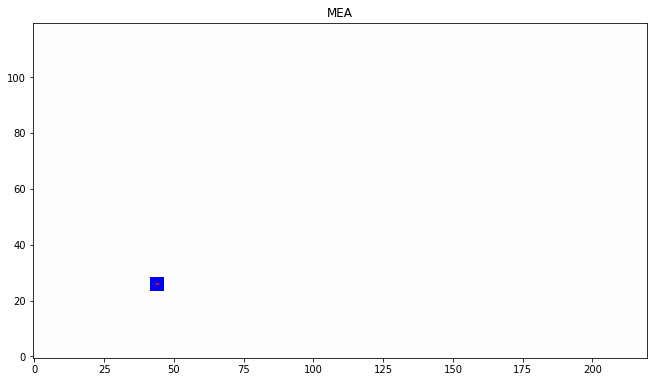

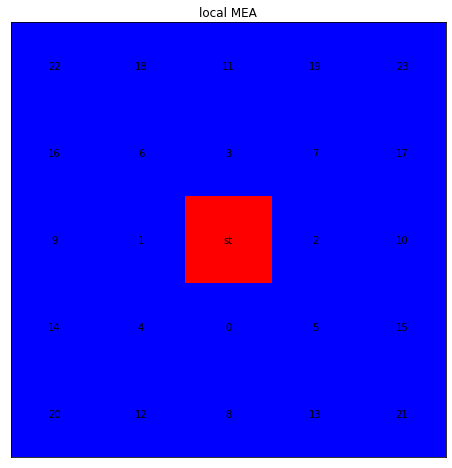

In [5]:
assay.disp_mea()
assay.disp_mea_local()

### 解析の概要

In [6]:
# 生データの読み込み
assay.loaddata()

In [7]:
# アーチファクト除去
# 500点計測,6trial,1000frameで30秒かかる
assay.cleanArtifact(eliminate_dist=18)

# 以下のデータが生成される
# - assay.data_raw   :　sigデータ
# - assay.data_filtered   :バンドパスフィルター後
# - assay.artifacts_c   :チャネル間で共通するアーチファクト
# - assay.data_cleaned_c   :チャネル間アーチファクトの除去後
# - assay.artifacts_t   :トライアル間で共通するアーチファクト
# - assay.data_cleaned_t   :トライアル間アーチファクトの除去後
# - assay.data_all_cleaned   :バンドパスフィルター後

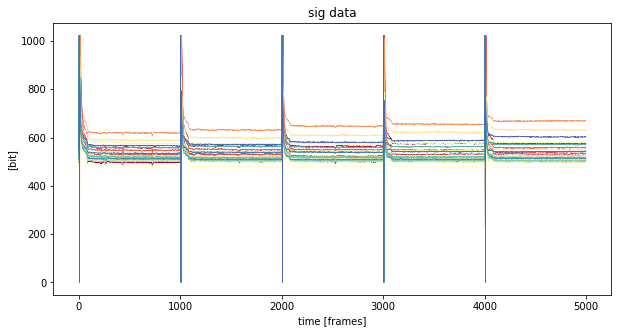

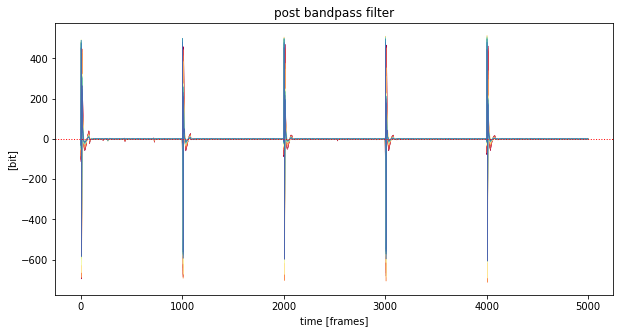

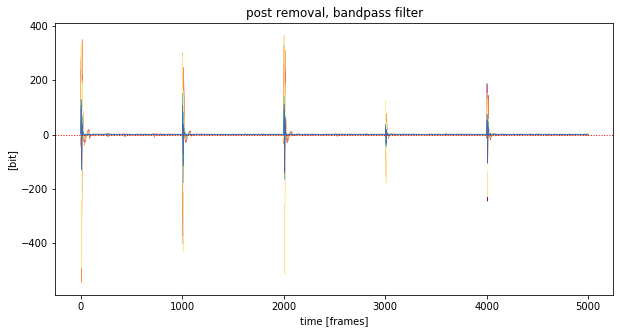

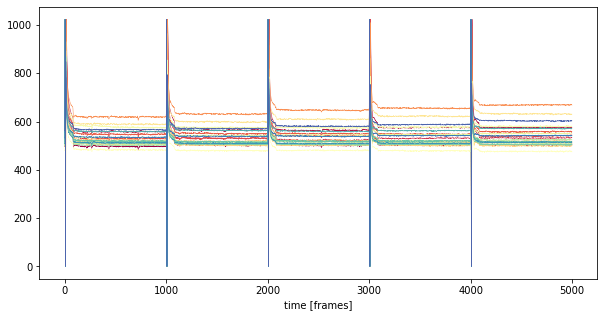

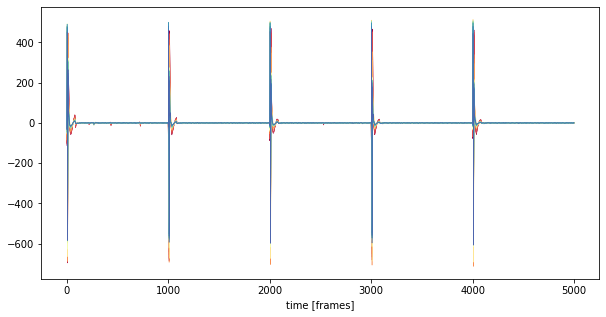

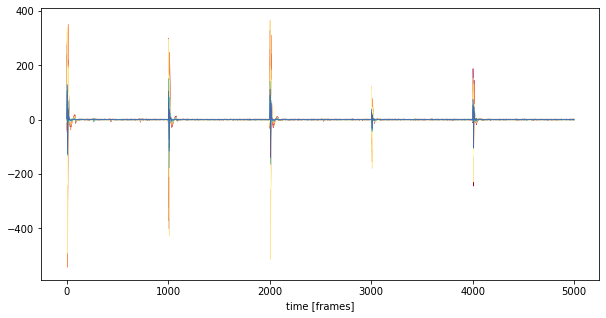

In [8]:
# trialをくっつけてデータを表示
assay.disp_raw()
assay.disp_filtered()
assay.disp_allcleaned()
# これも同じ意味。
assay.disp_data(assay.data_raw)
assay.disp_data(assay.data_filtered)
assay.disp_data(assay.data_all_cleaned)

### disp_*関数のパラメーター
基本的にdisp_*関数には以下の引数が使える。
- isConcat=True : trialをつなげて1つのグラフで表示するか
- ylabel=None : y軸のタイトル
- draw_xaxis=False  : x軸(y=0)を表示するか
- title=None : グラフのタイトル
- trange=None : 表示するtrialを指定 ::= None | int | [int] 
- yrange=None : y軸の幅 ::= [int, int]
- xids=None : 表示するチャネルをxidで指定 ::= None | int | [int] 
- drange=None : (使用頻度小) 表示するチャネルを刺激電極からの距離で指定 ::= [int, int]
- frange=None : 表示するframe数をnp.s_[int:int]で指定
- legend=False : 図の凡例を表示するか
- path=None : グラフを保存する場合のpathを指定


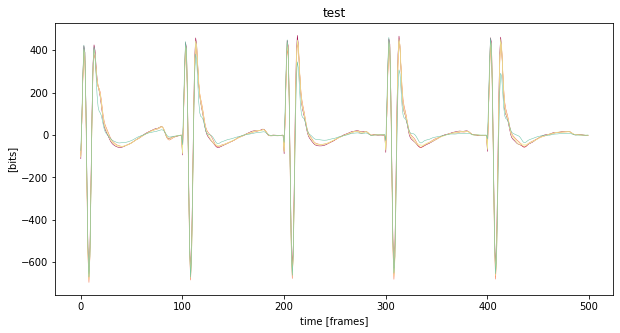

In [9]:
assay.disp_filtered(isConcat=True, ylabel='[bits]', draw_xaxis=False, title='test', 
                    trange=None, yrange=None,drange=None, frange=np.s_[:100], legend=False, xids=np.arange(5), path=None)


## アーチファクトの解析
アーチファクトの除去は2段階
- チャネル間で相関した波形の除去(disp_cleaned_c)
- トライアル間で相関した波形の除去(disp_cleaned_t)
- https://iopscience.iop.org/article/10.1088/1741-2552/aaa365/meta
- 論文では3段階で、もう一つは１刺激のパルス間での波形除去


### スパイクの確認

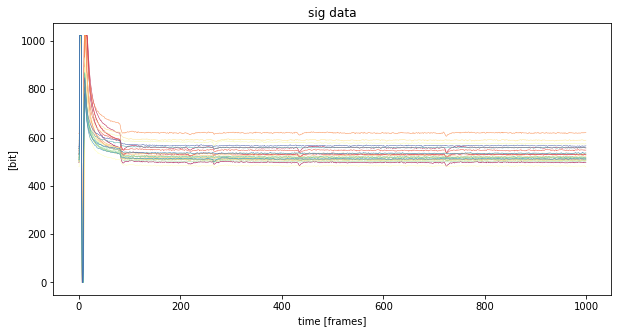

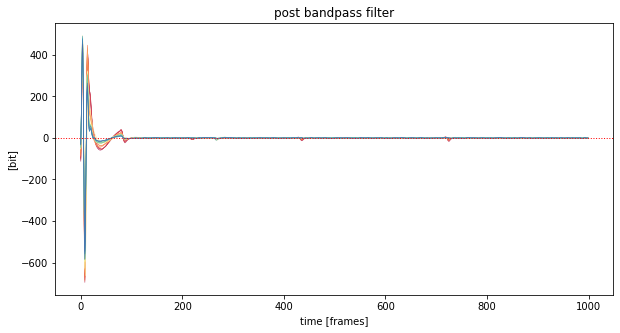

In [10]:
assay.disp_raw(trange=0)
assay.disp_filtered(trange=0)

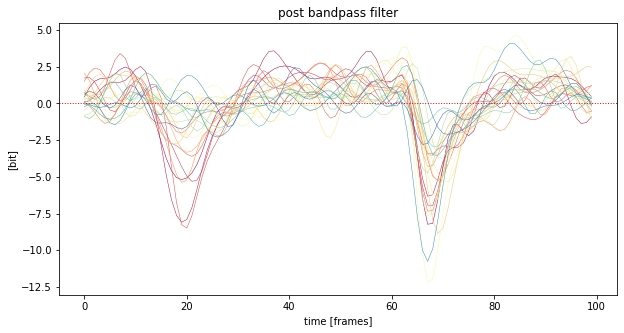

In [11]:
assay.disp_filtered(trange=0,frange=np.s_[20*10:20*15])

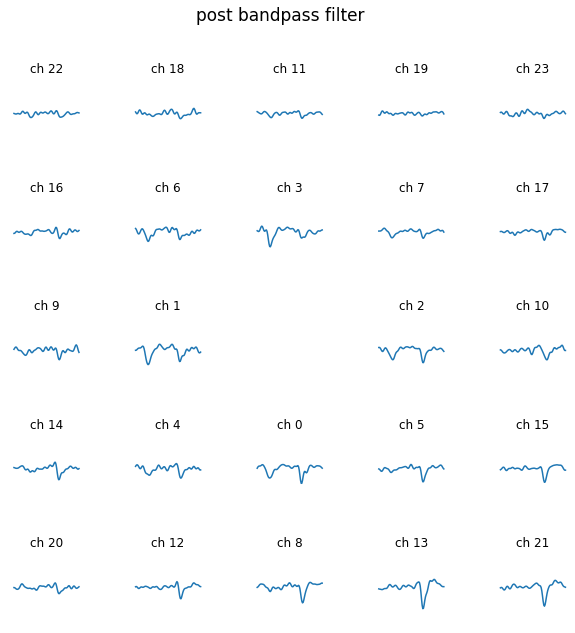

In [12]:
assay.disp_filtered_on_mea(trange=0, frange=np.s_[20*10:20*15],yrange=[-20,20], sp_pattern=None,show_spine=False, isDry=False)

### バンドパスフィルタの設定
先行研究では、カットオフ周波数が250Hzの4次のバターワースフィルタ(ハイパスフィルタ)が用いられていた。

MaxOneのデータは高周波のノイズ乗るので、今回の解析ではバンド幅が250-3000Hzのバターワースフィルタを採用した。
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
```
bpf = BandPassFilter(lowcut=250, highcut=3000, order=4)
```

以下は、バターワースフィルタのパラメーターの比較。

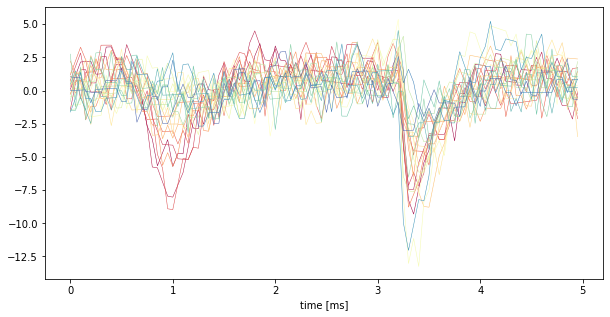

In [13]:
# 先行研究のハイパスフィルターだとギザギザになってしまう
from maxone_code.spikedetect import BandPassFilter,HighPassFilter
hpf = HighPassFilter(lowcut=250,order=4)
assay.hpfed_m=hpf.filter(assay.data_raw_m)
assay.hpfed=assay.hpfed_m[:,:,assay.BPF_MARGIN_FRAME:-assay.BPF_MARGIN_FRAME]
assay.drawer.draw(assay.hpfed[0,:,20*10:20*15])

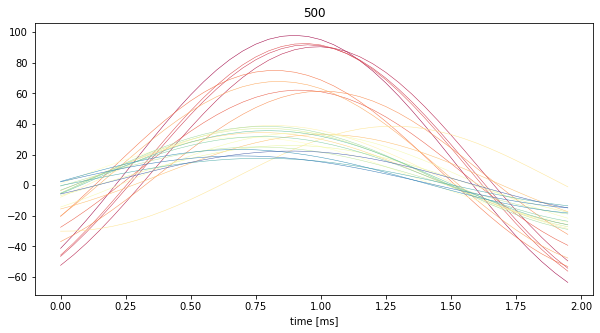

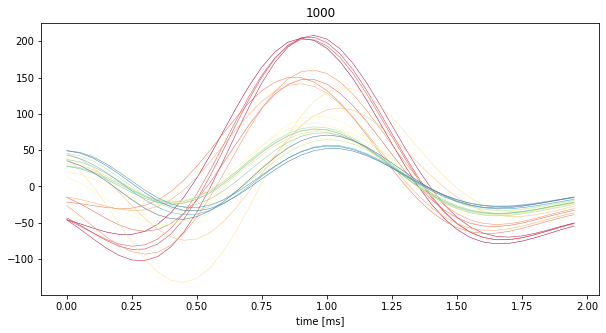

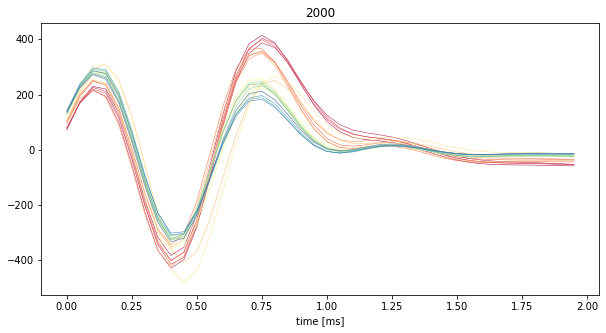

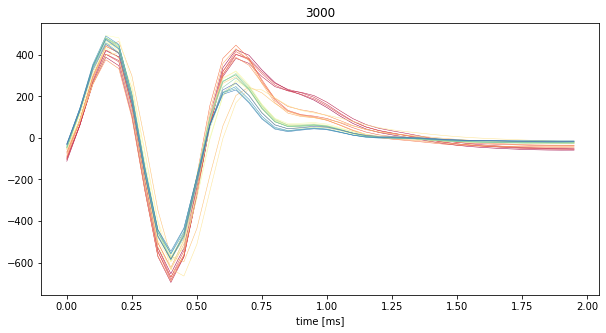

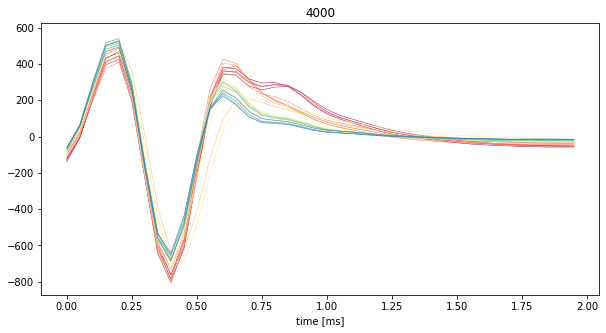

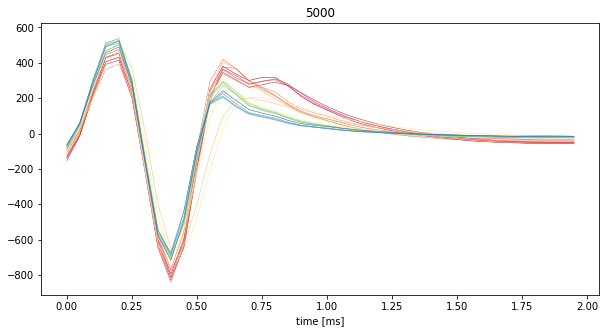

In [14]:
# 高周波のカットオフ周波数が小さすぎるとアーチファクトの波形が崩れる
from maxone_code.spikedetect import BandPassFilter,HighPassFilter

def disp_compare_filter(highcut, range_):
    bpf = BandPassFilter(lowcut=250, highcut=highcut, order=4)
    assay.bpfed_m=bpf.filter(assay.data_raw_m)
    assay.bpfed=assay.bpfed_m[:,:,assay.BPF_MARGIN_FRAME:-assay.BPF_MARGIN_FRAME]
    assay.drawer.draw(assay.bpfed[range_], title=str(highcut))

disp_compare_filter(500, np.s_[0,:,20*0:20*2])
disp_compare_filter(1000, np.s_[0,:,20*0:20*2])
disp_compare_filter(2000, np.s_[0,:,20*0:20*2])
disp_compare_filter(3000, np.s_[0,:,20*0:20*2])
disp_compare_filter(4000, np.s_[0,:,20*0:20*2])
disp_compare_filter(5000, np.s_[0,:,20*0:20*2])

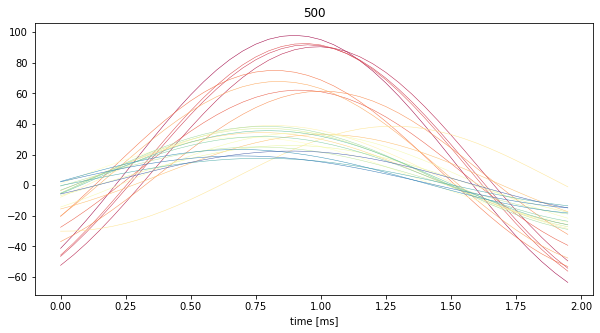

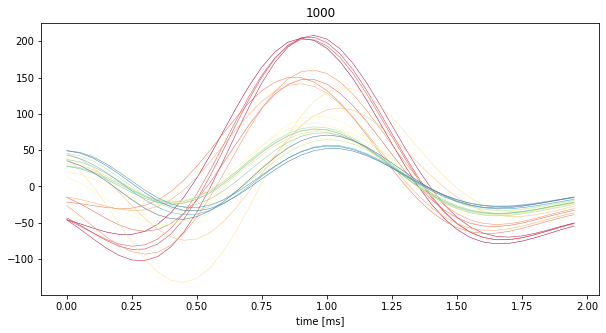

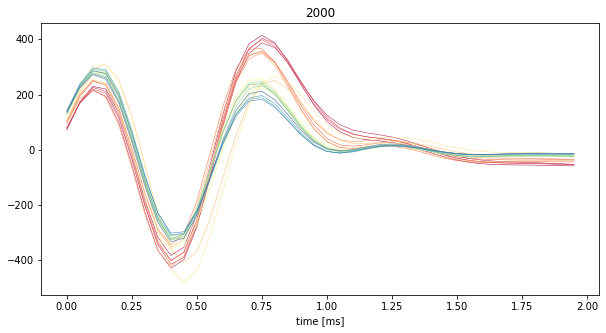

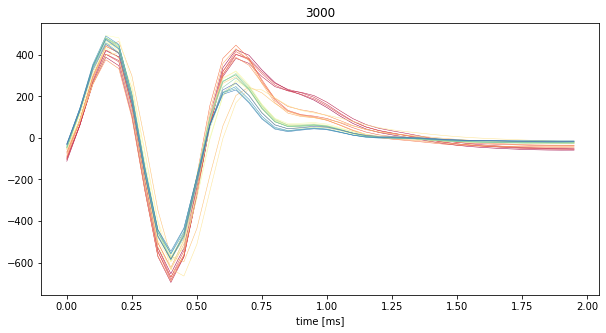

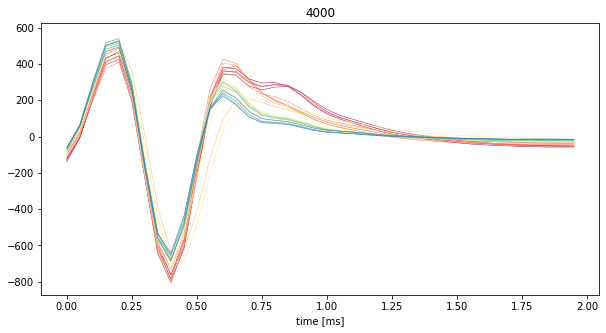

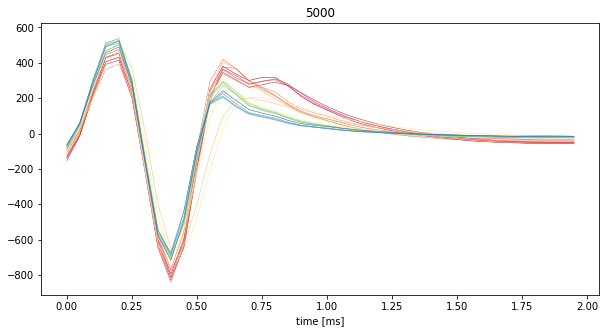

In [15]:

disp_compare_filter(500, np.s_[0,:,20*0:20*2])
disp_compare_filter(1000, np.s_[0,:,20*0:20*2])
disp_compare_filter(2000, np.s_[0,:,20*0:20*2])
disp_compare_filter(3000, np.s_[0,:,20*0:20*2])
disp_compare_filter(4000, np.s_[0,:,20*0:20*2])
disp_compare_filter(5000, np.s_[0,:,20*0:20*2])

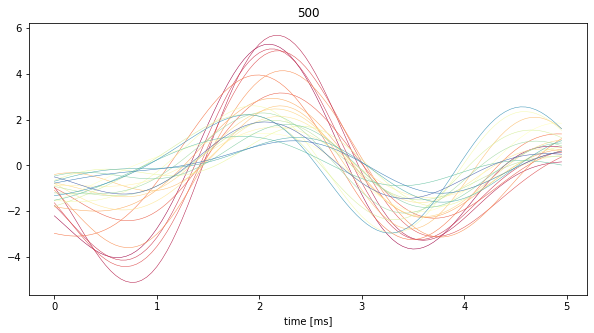

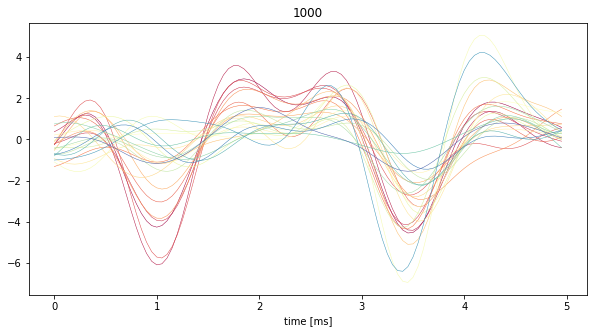

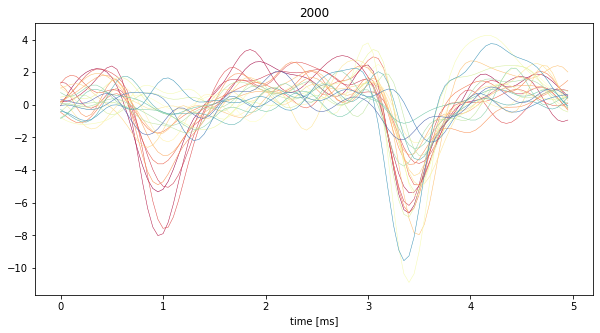

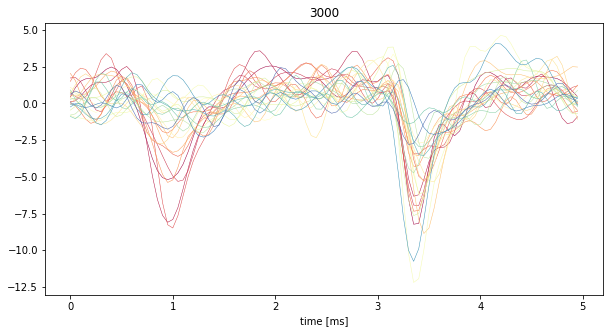

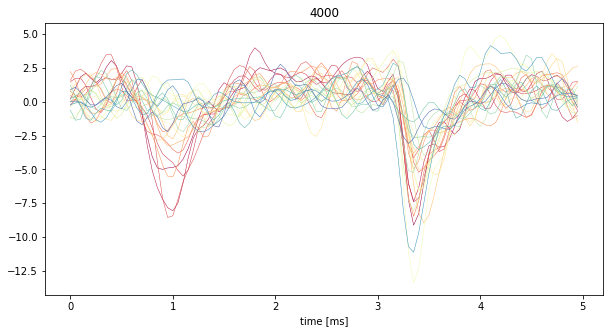

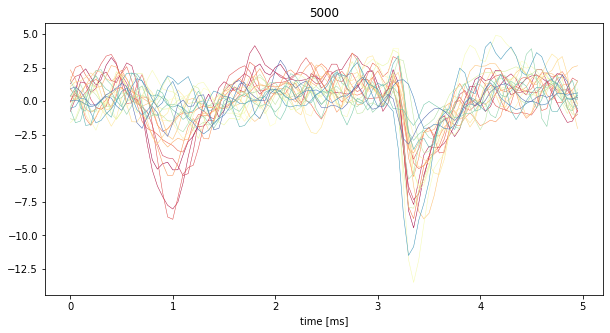

In [16]:

disp_compare_filter(500, np.s_[0,:,20*10:20*15])
disp_compare_filter(1000, np.s_[0,:,20*10:20*15])
disp_compare_filter(2000, np.s_[0,:,20*10:20*15])
disp_compare_filter(3000, np.s_[0,:,20*10:20*15])
disp_compare_filter(4000, np.s_[0,:,20*10:20*15])
disp_compare_filter(5000, np.s_[0,:,20*10:20*15])

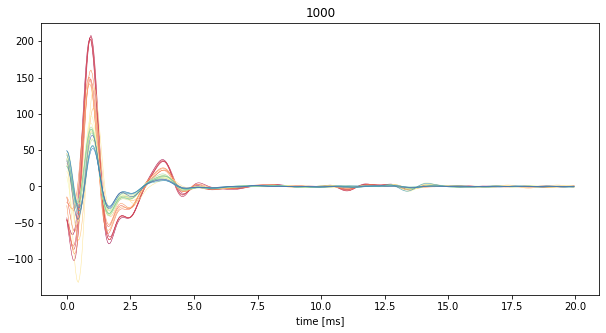

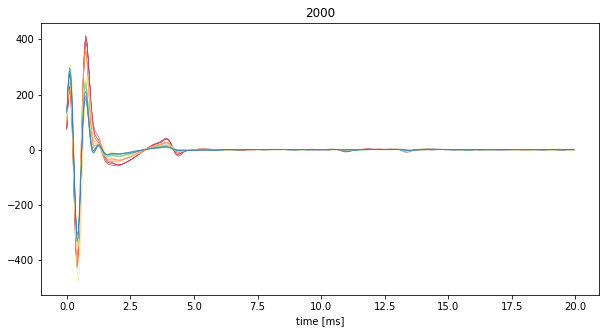

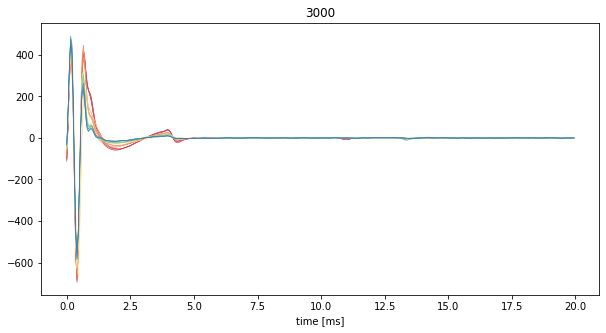

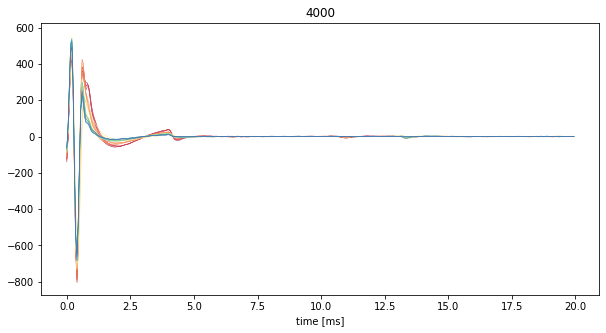

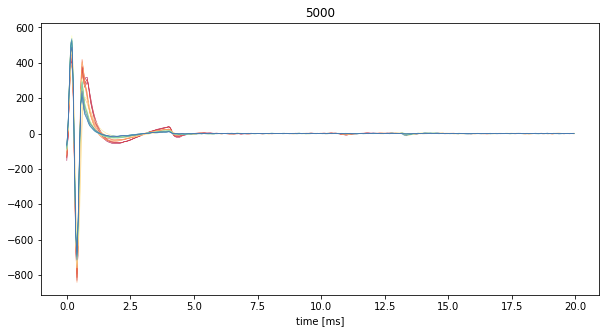

In [17]:

disp_compare_filter(1000, np.s_[0,:,20*0:20*20])
disp_compare_filter(2000, np.s_[0,:,20*0:20*20])
disp_compare_filter(3000, np.s_[0,:,20*0:20*20])
disp_compare_filter(4000, np.s_[0,:,20*0:20*20])
disp_compare_filter(5000, np.s_[0,:,20*0:20*20])

### アーチファクトの確認

In [18]:
assay.chan_dist_table

array([[ 0.        , 24.74873734, 24.74873734, 35.        , 17.5       ,
        17.5       , 39.13118961, 39.13118961, 17.5       , 39.13118961,
        39.13118961, 52.5       , 24.74873734, 24.74873734, 35.        ,
        35.        , 49.49747468, 49.49747468, 55.33985905, 55.33985905,
        39.13118961, 39.13118961, 63.09714732, 63.09714732],
       [24.74873734,  0.        , 35.        , 24.74873734, 17.5       ,
        39.13118961, 17.5       , 39.13118961, 39.13118961, 17.5       ,
        52.5       , 39.13118961, 35.        , 49.49747468, 24.74873734,
        55.33985905, 24.74873734, 55.33985905, 35.        , 49.49747468,
        39.13118961, 63.09714732, 39.13118961, 63.09714732],
       [24.74873734, 35.        ,  0.        , 24.74873734, 39.13118961,
        17.5       , 39.13118961, 17.5       , 39.13118961, 52.5       ,
        17.5       , 39.13118961, 49.49747468, 35.        , 55.33985905,
        24.74873734, 55.33985905, 24.74873734, 49.49747468, 35.        ,
  

In [19]:
# 主成分分析する範囲の変更
start_frame=0
stop_frame=300
sel=np.s_[start_frame:stop_frame+1]
assay.cleanArtifact(slice=sel, eliminate_dist=18)

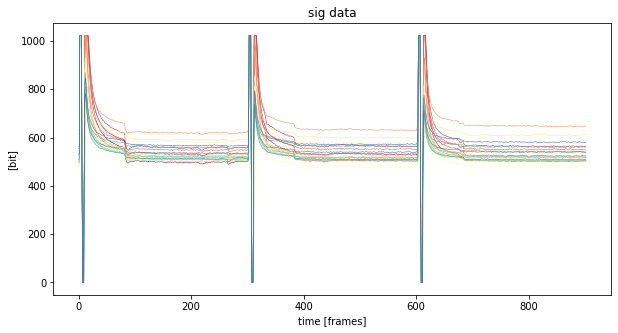

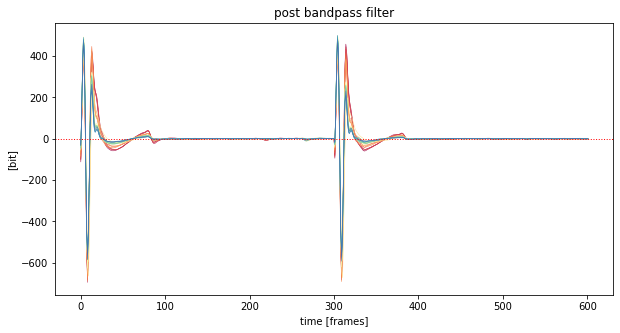

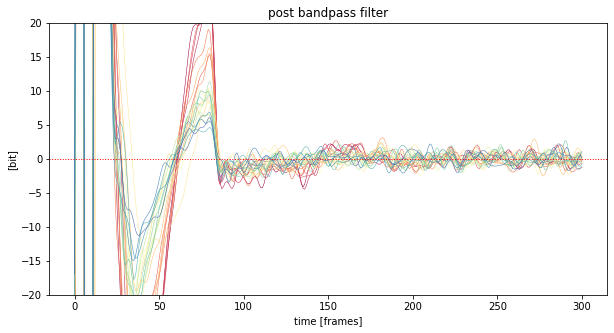

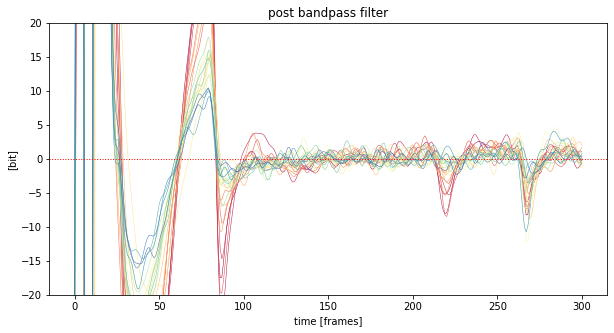

In [20]:
assay.disp_raw(trange=[0,1,2])
assay.disp_filtered(trange=[0,1])
assay.disp_filtered(trange=[1],yrange=[-20,20])
assay.disp_filtered(trange=[0],yrange=[-20,20])

アーチファクトは8msまでのる

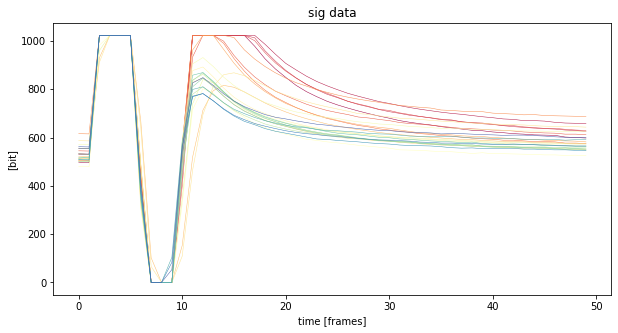

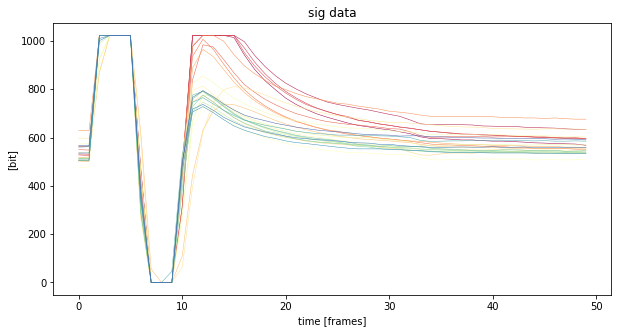

In [21]:
assay.disp_raw(trange=[0], frange=np.s_[:50])
assay.disp_raw(trange=[1], frange=np.s_[:50])

1msまで刺激電極付近はサチる

### 主成分分析の範囲の設定

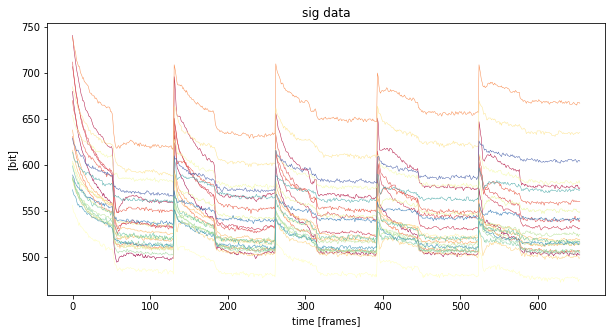

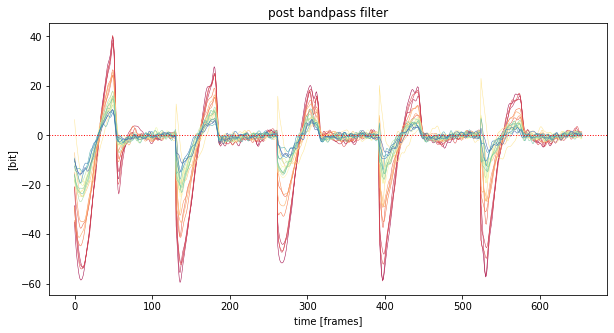

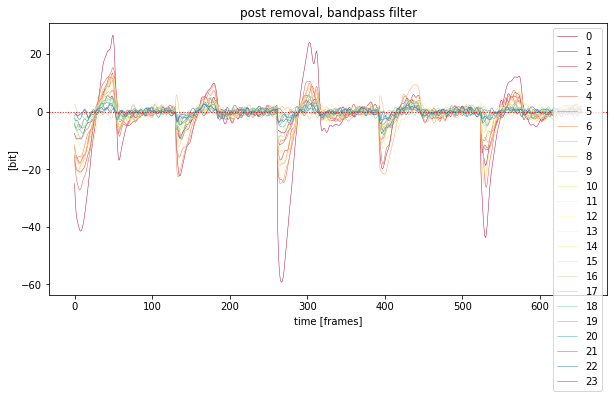

In [22]:
# 主成分分析する範囲の変更
start_frame=30
stop_frame=160
sel=np.s_[start_frame:stop_frame+1]
assay.cleanArtifact(sel, eliminate_dist=20)
assay.disp_raw()
assay.disp_filtered()
# assay.disp_artifacts_all()
assay.disp_allcleaned(legend=True)

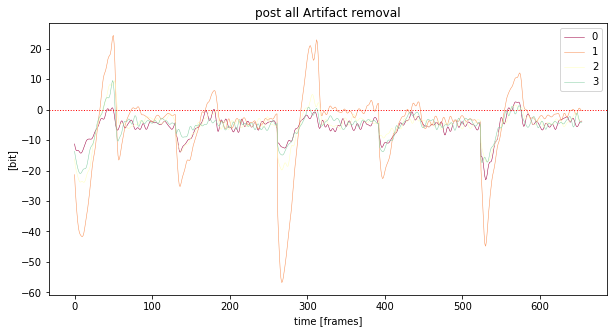

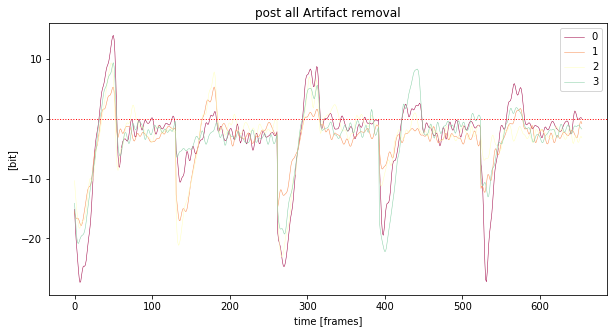

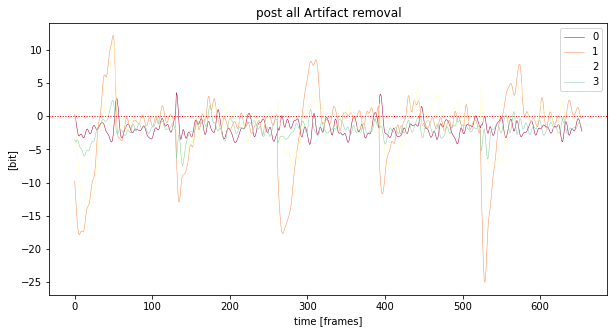

In [23]:
assay.disp_cleaned_t(xids=[0,1,2,3], legend=True)
assay.disp_cleaned_t(xids=[4,5,6,7], legend=True)
assay.disp_cleaned_t(xids=[8,9,10,11], legend=True)

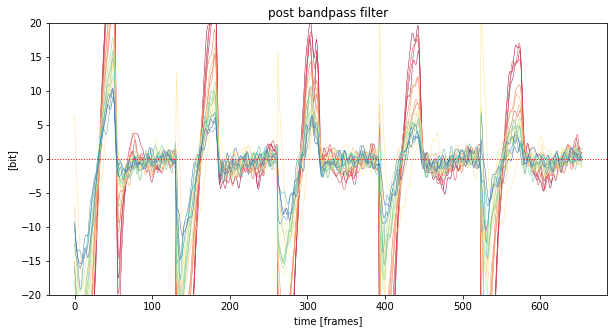

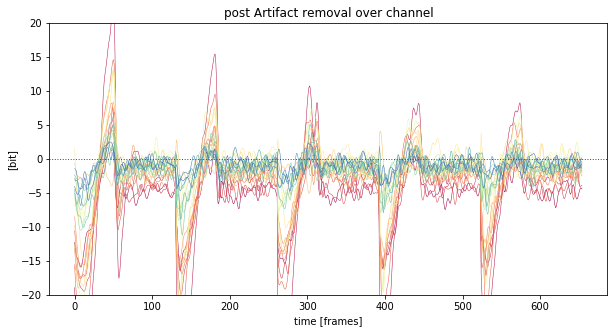

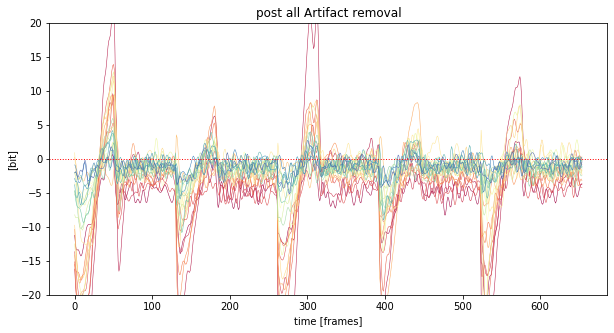

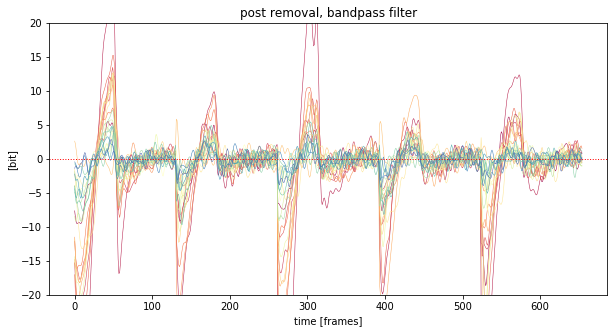

In [24]:

assay.disp_filtered(yrange=[-20,20])
assay.disp_cleaned_c(yrange=[-20,20])
assay.disp_cleaned_t(yrange=[-20,20])
assay.disp_allcleaned(yrange=[-20,20])

### MEA上で活動データを表示

In [25]:
# 主成分分析する範囲の変更
start_frame=30
stop_frame=160
sel=np.s_[start_frame:stop_frame+1]
assay.cleanArtifact(sel, eliminate_dist=10)

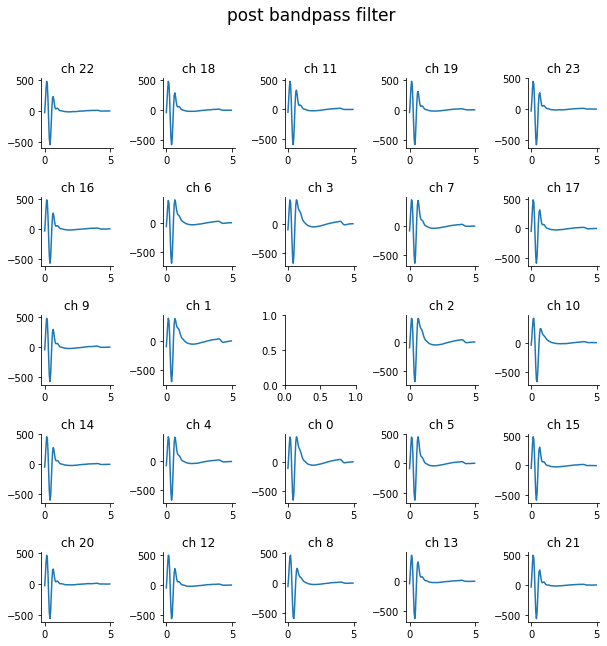

In [26]:
assay.disp_filtered_on_mea(sp_pattern=None, frange=np.s_[:100], trange=[0])

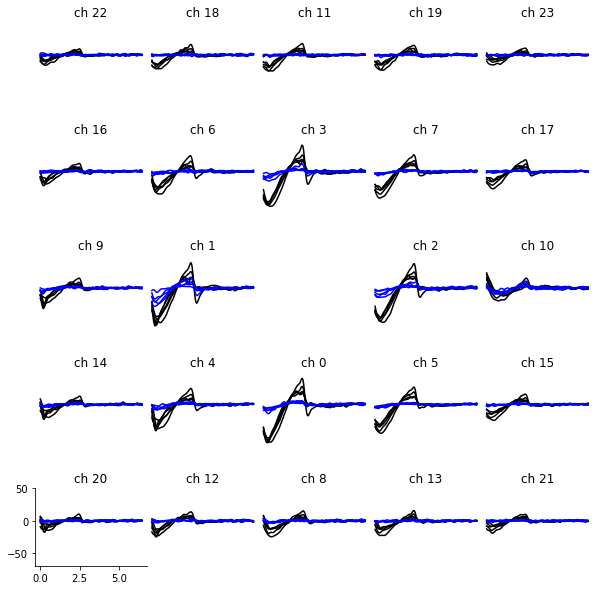

In [27]:
sel=np.s_[30:160]
assay.disp_beforeafter_all(frange=sel, sp_pattern=(1,(5, 5),None),
                           share_axis=True, show_spine=False, hspace=0.5, wspace=0, isDry=False)